Alexa Marcovecchio

Assignment 13

November 23, 2020

### Forecast Evolution Discussion:
My short term forecasts have improved over time.  I have been mostly relying on my "human brain" rather than regression code to develop forecasts, and it has been paying off recently.  I noticed that since precipitation is not falling directly onto the streamflow measurement site, changes in streamflow follow a fairly consistent trend over a timescale of two weeks, as long as precipitation to the north remains fairly consistent.  My long term forecasts have improved slightly since I started using the driest years on record instead of the entire 30 year period to calculate the average weekly streamflow values. 



## Import packages and define functions to be used in this script.

The cell below defines the function that retrieves the forecast dates for each week.  It allows me to quickly retrieve the range of dates I need to collect data for and analyze. It works by accessing the csv file containing the forecast dates as strings and then converting them to datetime format for easier access.

In [11]:

import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import geopandas as gpd
import fiona
import contextily as ctx
import os
import numpy as np


def getForecastDates():
    """Get dataframe of forecast dates from csv file.

    -------------------------------------------------
    Parameters: None

    -------------------------------------------------
    Outputs:
    forecast dates = dataframe
                     contains columns with start and end
                     dates split up into
                     year, month, and day
    """
    #  Read in the forecast dates for each week from csv
    filename = os.path.join('../data',
                            "Seasonal_Forecast_Dates.csv")
    forecast_dates = pd.read_csv(filename, skiprows=1,
                                 names=['week', 'start_date', 'end_date'])
    forecast_dates[["start_year", "start_month", "start_day"]] \
        = forecast_dates["start_date"].\
        astype(str).str.split("-", expand=True)

    # split forecast start and end dates into year, month, and day
    forecast_dates['start_year'] = forecast_dates['start_year'].astype(int)
    forecast_dates['start_month'] = forecast_dates['start_month'].astype(int)
    forecast_dates['start_day'] = forecast_dates['start_day'].astype(int)
    forecast_dates[["end_year", "end_month", "end_day"]] \
        = forecast_dates["end_date"].\
        astype(str).str.split("-", expand=True)
    forecast_dates['end_year'] = forecast_dates['end_year'].astype(int)
    forecast_dates['end_month'] = forecast_dates['end_month'].astype(int)
    forecast_dates['end_day'] = forecast_dates['end_day'].astype(int)

    return forecast_dates


## Plot recent streamflow data to determine 1 and 2 week streamflow forecasts.

![](assets/Marcovecchio_HW13_lineplot.png)

![](assets/Marcovecchio_HW13_box_and_whisker.png)

This lineplot shows that in recent days, the streamflow has remained near constant or has been very slowly decreasing.  This prompted me to expect a decrease in weekly average streamflow of approximately 3 cfs or less for the next two weeks.The box and whisker plot shows that current streamflows are near the higher end of the streamflow values we have seen throughout the semester.  This further supported my prediction that streamflow will likely start to decrease.



No handles with labels found to put in legend.
Based on streamflow plots:
week 1 forecast: 153 cfs
week 2 forecast: 150 cfs


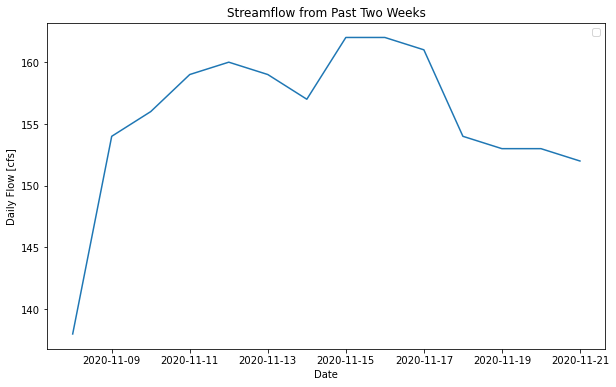

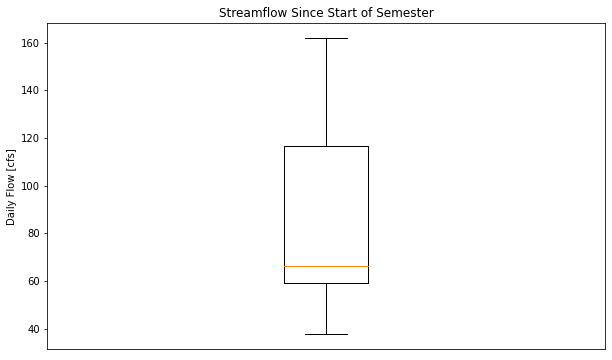

In [12]:
# Read the data into a pandas dataframe
url_usgs = 'https://waterdata.usgs.gov/nwis/dv?cb_00060=on' \
           '&format=rdb&site_no=09506000&referred_module=sw' \
           '&period=&begin_date=1989-01-01&end_date=2020-11-21'

data = pd.read_table(url_usgs, skiprows=30, names=['agency_cd', 'site_no',
                                                   'datetime', 'flow', 'code'],
                     parse_dates=['datetime'])

# Expand the dates to year month day
data['year'] = pd.DatetimeIndex(data['datetime']).year
data['month'] = pd.DatetimeIndex(data['datetime']).month
data['day'] = pd.DatetimeIndex(data['datetime']).dayofweek
data['dayofweek'] = pd.DatetimeIndex(data['datetime']).dayofweek

# Aggregate flow values to weekly
flow_weekly = data.resample("W", on='datetime').mean()

# Plot daily streamflow
fig, ax = plt.subplots()
ax.plot(data['datetime'].tail(14), data['flow'].tail(14), color='C0')
ax.set(title="Streamflow from Past Two Weeks",
       xlabel="Date", ylabel="Daily Flow [cfs]")
ax.legend()
fig.set_size_inches(10, 6)

# Plot year to date streamflow
fig, ax = plt.subplots()
ax.boxplot(data['flow'].tail(92))
ax.set(title="Streamflow Since Start of Semester",
       ylabel="Daily Flow [cfs]")
ax.xaxis.set_visible(False)
fig.set_size_inches(10, 6)

print('Based on streamflow plots:')
print('week 1 forecast: 153 cfs')
print('week 2 forecast: 150 cfs')

## Make map of September 2020 mean average precipitation in order to determine where the majority of precipitation is falling.

![](assets/Marcovecchio_HW13_map.png)

This map shows that the precipitation contributing to streamflow at Camp Verde is not falling at the measurement site.  This likely contributes to the lag between precipitation events and streamflow increases, as well as the slower, steadier changes in streamflow amount.

(-117.8125, -107.1875, 29.75, 40.75)

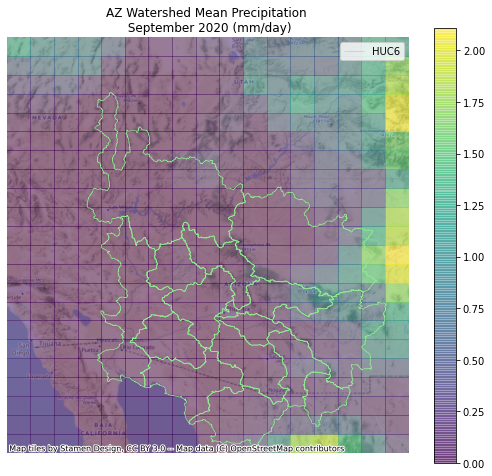

In [13]:
# Read ncdf precip file
data_path = os.path.join('../data',
                         'MERRA2_401.tavgM_2d_int_Nx.202009.SUB.nc')

# Read in the dataset as an x-array
dataset = xr.open_dataset(data_path)

# Sum different types of precip
PREC = dataset['PRECCU'] + dataset['PRECLS'] + dataset['PRECSN']

# convert to mm/day
PREC.values = PREC.values*86400.

# slice to fit crs of HUC6
PREC_az = PREC.sel(lat=slice(30, 40.5),
                   lon=slice(-118, -107))

file = os.path.join('../data', 'WBD_15_HU2_GDB.gdb')
fiona.listlayers(file)
HUC6 = gpd.read_file(file, layer="WBDHU6")

fig, ax = plt.subplots(figsize=(9, 8))
HUC6.boundary.plot(ax=ax, color=None,
                   edgecolor='lightgreen',
                   linewidth=0.7,
                   zorder=2,
                   label='HUC6')
ctx.add_basemap(ax, crs=HUC6.crs, zorder=0)
PREC_az.plot(ax=ax,
             zorder=1,
             alpha=0.5,
             label='Precipitation (mm/day)')
ax.set_title('AZ Watershed Mean Precipitation \n September 2020 (mm/day)')
ax.legend()
ax.axis('off')

## Prepare 16 week forecast using 30 year averaging method.

For my 16 week forecast, I found the 5 years with the lowest streamflow based on the annual average streamflow. Then, I averaged the streamflow from those five years for the days within each forecast period in order to get the weekly average streamflow.

In [14]:
# get data from beginning of semester
url_usgs_16wk = 'https://waterdata.usgs.gov/nwis/dv?cb_00060=on' \
           '&format=rdb&site_no=09506000&referred_module=sw' \
           '&period=&begin_date=1989-01-01&end_date=2020-08-29'
data_16wk = pd.read_table(url_usgs_16wk, skiprows=30, names=['agency_cd',
                                                             'site_no',
                                                             'datetime',
                                                             'flow', 'code'],
                          parse_dates=['datetime'])

# Expand the dates to year month day and set them as integers
data_16wk[["year", "month", "day"]] = data_16wk["datetime"].\
                                 astype(str).str.split("-", expand=True)
data_16wk['year'] = data_16wk['year'].astype(int)  # year integer
data_16wk['month'] = data_16wk['month'].astype(int)  # month integer
data_16wk['day'] = data_16wk['day'].astype(int)  # day integer

# get annual average streamflow
year_means = np.zeros((32, 2))
for j in range(1989, 2021):
    year_means[j-1989, 0] = j
    year_means[j-1989, 1] = data_16wk[data_16wk.year == j].flow.mean()

# find the five driest years on record using nsmallest
driest = pd.DataFrame(year_means, columns=['year', 'mean']).\
         nsmallest(5, 'mean')
driest.index = range(5)
driest['year'] = driest['year'].astype(int)

# make a dataframe that only contains data from the driest years
dry_years_data = data_16wk[(data_16wk.year == driest.year[0]) |
                           (data_16wk.year == driest.year[1]) |
                           (data_16wk.year == driest.year[2]) |
                           (data_16wk.year == driest.year[3]) |
                           (data_16wk.year == driest.year[4])
                           ]

forecast_dates = getForecastDates()

# initialize list for weekly forecasts
forecasts = []

# go through each week and get the means for each week
for i in range(16):

    # if the forecast week starts and ends in different months
    if (forecast_dates.start_month[i] != forecast_dates.end_month[i]):
        # set the date of the last day of the month
        if(forecast_dates.start_month[i] == 8):
            last_day = 31
        if(forecast_dates.start_month[i] == 9):
            last_day = 30
        if(forecast_dates.start_month[i] == 10):
            last_day = 31
        if(forecast_dates.start_month[i] == 11):
            last_day = 30
        # take average of all dates within the forecast week during dry years
        wk_mean = dry_years_data[((dry_years_data.month ==
                                   forecast_dates.start_month[i]) &
                                 (dry_years_data.day >=
                                  forecast_dates.start_day[i]) &
                                 (dry_years_data.day <= last_day)) |
                                 ((dry_years_data.month ==
                                  forecast_dates.end_month[i]) &
                                 (dry_years_data.day >= 1) &
                                 (dry_years_data.day <=
                                  forecast_dates.end_day[i]))].flow.mean()
        # add weekly mean to forecast lists
        forecasts.append(wk_mean)

    # if the forecast week starts and ends in the same month
    else:
        # take average of all dates within forecast week during dry years
        wk_mean = dry_years_data[(dry_years_data.month ==
                                  forecast_dates.start_month[i]) &
                                 (dry_years_data.day >=
                                  forecast_dates.start_day[i]) &
                                 (dry_years_data.day <=
                                  forecast_dates.end_day[i])].flow.mean()
        # add weekly mean to forecast lists
        forecasts.append(wk_mean)

print('Weekly Forecasts:', forecasts)

Weekly Forecasts: [223.72749999999996, 127.30571428571427, 258.6, 152.05714285714285, 107.97714285714287, 112.48571428571428, 181.1657142857143, 144.48000000000002, 142.9142857142857, 151.8, 150.6, 164.05714285714285, 170.31428571428572, 174.82857142857142, 186.45714285714286, 190.54285714285714]
